# **Default Setting**

* Python: 3.6.9
* ML Framework: tf-nightly-gpu 2.5.0-dev20201208
* CPU: AMD Ryzen 5 5600X 6-Core Processor
* GPU: GeForce RTX 3070 (8G) (CUDA 11.1)
* RAM: 32G
* Platform: linux 20.04 LTS

Install below APIs using anaconda.

* conda create -n py36 python=3.6.9
* conda acitvate py36
* pip3 install tf-nightly-gpu
* pip3 install tensorflow-addons
* conda install pandas, matplotlib

And now, you can run jupyter lab (or jupyter notebook).

In [1]:
%env NOTEBOOKNAME try25
%env LOCAL_DATA_PATH data
%env SUBMISSION_PATH submission

env: NOTEBOOKNAME=try25
env: LOCAL_DATA_PATH=data
env: SUBMISSION_PATH=submission


In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import datetime
import gc
import glob
import os
import platform

import numpy as np
import pandas as pd

from collections import OrderedDict
from matplotlib import pyplot as plt

print(f"tf.__version__: {tf.__version__}")
print(f"tfa.__version__: {tfa.__version__}")

tf.__version__: 2.5.0-dev20201208
tfa.__version__: 0.11.2


/home/myunggyo/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20201208). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# !python -V

In [5]:
# !cat /proc/cpuinfo

In [6]:
!nvidia-smi

Mon Dec 21 04:01:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Graphics Device     On   | 00000000:0A:00.0  On |                  N/A |
|  0%   31C    P8    19W / 220W |    338MiB /  7979MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# !df -h

In [8]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           31Gi       2.6Gi        25Gi       432Mi       3.0Gi        27Gi
Swap:         2.0Gi          0B       2.0Gi


In [9]:
# platform.platform()

In [10]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# **Define Arguments**

In [11]:
args = OrderedDict({
    # Basic
    "SEED": 42,
    "TEST_SIZE": 0.2,
    "EPOCH": 10,
    "INIT_LR": 1e-3,
    
    # Dataframe
    "NUM_TEST_CSV": 81,
    
    # Dataset Pipeline
    "WINDOW_INP": 7 * 24 * 2, # 336, 7 days
    "WINDOW_TAR": 2 * 24 * 2, # 96, 2 days
    "WINDOW_SHIFT": 1 * 24 * 2, # 1 day
    "WINDOW_STRIDE": 1,
    "WINDOW_DR": True, # Drop remainders
    "AUTO": tf.data.experimental.AUTOTUNE,
    
    "GLOBAL_BATCH_SIZE": 128,
    
    # Model
    "NUM_UNITS": 64, # lstm units
    "NUM_FEATURES": 7, # Day_sin, Day_cos, DHI, DNI, WS, RH, T
    "NUM_QUANTILE": 9, # tau = 0.1 to 0.9
    
})

args

OrderedDict([('SEED', 42),
             ('TEST_SIZE', 0.2),
             ('EPOCH', 10),
             ('INIT_LR', 0.001),
             ('NUM_TEST_CSV', 81),
             ('WINDOW_INP', 336),
             ('WINDOW_TAR', 96),
             ('WINDOW_SHIFT', 48),
             ('WINDOW_STRIDE', 1),
             ('WINDOW_DR', True),
             ('AUTO', -1),
             ('GLOBAL_BATCH_SIZE', 128),
             ('NUM_UNITS', 64),
             ('NUM_FEATURES', 7),
             ('NUM_QUANTILE', 9)])

# **Load Datasets**

## **Train / Validation**

```
"""Using sklearn.model_selection.train_test_split()"""

tr_df, vl_df = train_test_split(
    df, 
    test_size = args["TEST_SIZE"]
    random_state = args["SEED"])
    
```

In [12]:
df = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "train", "train.csv"))

In [13]:
# df.head()

In [14]:
# df.describe()

In [15]:
args["SPLIT_LEN"] = int(df.shape[0] * (1. - args["TEST_SIZE"]))

tr_df = df[:args["SPLIT_LEN"]]
vl_df = df[args["SPLIT_LEN"]:]

tr_df.shape, vl_df.shape

((42048, 9), (10512, 9))

In [16]:
def preprocessing(df, is_training = True, day = 24 * 60 * 60): # day must be represented by sec
    # Drop timestampes.
    try:
        # We cannot use day features, thus there is no day-position in test dataset.
        df = df.drop(["Day"], axis = 1) 
    except:
        pass
    
    
    # Timestamp to sin/cos.
    for column in ["Hour", "Minute"]:
        df[f"_{column}"] = df[column].apply(lambda x: f"{x:0>2d}")
    
    df["Time"] = df[["_Hour", "_Minute"]].apply(lambda x: ":".join(x), axis = 1)
    
    timestamp = pd.to_datetime(df["Time"], format = "%H:%M").map(datetime.datetime.timestamp)
        
    day_sin = np.sin(timestamp * (2 * np.pi / day))
    day_cos = np.cos(timestamp * (2 * np.pi / day))
        
    df.insert(loc = 0, column = "DAY_SIN", value = day_sin)
    df.insert(loc = 1, column = "DAY_COS", value = day_cos)
    
    df = df.drop(["Hour", "Minute", "_Hour", "_Minute", "Time"], axis = 1)
    
    
    # Standarize.
    for column in ["DHI", "DNI", "WS", "RH", "T"]: # without DAY_SIN, DAY_COS, TARGET
        if is_training:
            args[f"{column}_MEAN"] = df[column].mean()
            args[f"{column}_STD"] = df[column].std()
        
        df[column] = (df[column] - args[f"{column}_MEAN"]) / args[f"{column}_STD"]
        
    return df

In [17]:
tr_df = preprocessing(tr_df)
vl_df = preprocessing(vl_df, is_training = False)

In [18]:
tr_df

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
0,-0.798985,-0.601350,-0.620599,-0.668244,-0.677079,0.527259,-2.018496,0.0
1,-0.870642,-0.491917,-0.620599,-0.668244,-0.677079,0.526338,-2.018496,0.0
2,-0.927402,-0.374067,-0.620599,-0.668244,-0.608733,0.651615,-2.018496,0.0
3,-0.968293,-0.249817,-0.620599,-0.668244,-0.608733,0.650234,-2.018496,0.0
4,-0.992617,-0.121292,-0.620599,-0.668244,-0.608733,0.809133,-2.018496,0.0
...,...,...,...,...,...,...,...,...
42043,-0.267799,-0.963475,-0.620599,-0.668244,-0.403696,1.003958,-0.138217,0.0
42044,-0.391267,-0.920277,-0.620599,-0.668244,0.074724,1.351695,-0.138217,0.0
42045,-0.508040,-0.861334,-0.620599,-0.668244,0.348107,1.644624,-0.237179,0.0
42046,-0.616120,-0.787652,-0.620599,-0.668244,0.621489,1.719237,-0.237179,0.0


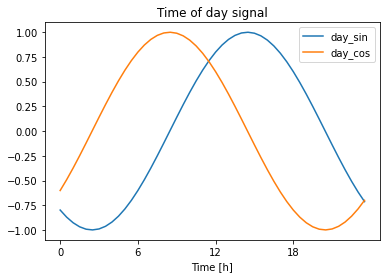

In [19]:
plt.plot(np.array(tr_df["DAY_SIN"])[:48], label = "day_sin")
plt.plot(np.array(tr_df["DAY_COS"])[:48], label = "day_cos")
plt.legend()
plt.xticks(np.arange(0, 48, 12), np.arange(0, 24, 6))
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

In [20]:
tr_df.describe()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
count,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,4.204800e+04,42048.000000
mean,3.279092e-13,-1.392590e-13,4.461170e-17,-5.542666e-17,-2.500959e-16,2.893001e-16,7.976031e-17,17.757092
std,7.071152e-01,7.071152e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,25.726194
min,-9.999567e-01,-9.999567e-01,-6.205988e-01,-6.682443e-01,-1.702264e+00,-2.304841e+00,-2.711231e+00,0.000000
25%,-7.037852e-01,-7.037852e-01,-6.205988e-01,-6.682443e-01,-7.454246e-01,-7.605199e-01,-8.309515e-01,0.000000
50%,2.563233e-12,2.563233e-12,-6.205988e-01,-6.682443e-01,-1.986590e-01,4.871736e-02,-1.382169e-01,0.000000
75%,7.037852e-01,7.037852e-01,2.179613e-01,6.501994e-01,4.847981e-01,7.211627e-01,7.524418e-01,31.907314
max,9.999567e-01,9.999567e-01,4.468593e+00,2.353903e+00,6.499220e+00,1.951369e+00,2.632721e+00,99.913939


In [21]:
vl_df.describe()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
count,1.051200e+04,1.051200e+04,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000
mean,3.279124e-13,-1.392591e-13,-0.002051,0.009001,-0.118357,-0.193249,0.437047,17.924783
std,7.071404e-01,7.071404e-01,1.007151,0.989575,0.862562,1.062334,0.960019,25.895349
min,-9.999567e-01,-9.999567e-01,-0.620599,-0.668244,-1.702264,-2.254638,-1.919534,0.000000
25%,-7.037852e-01,-7.037852e-01,-0.620599,-0.668244,-0.745425,-1.066805,-0.336141,0.000000
50%,2.563233e-12,2.563233e-12,-0.620599,-0.668244,-0.267005,-0.238223,0.455556,0.000000
75%,7.037852e-01,7.037852e-01,0.227600,0.744374,0.416452,0.568941,1.148290,32.659510
max,9.999567e-01,9.999567e-01,4.420400,2.251167,3.902083,1.951369,2.632721,99.453605


## **Test**

In [22]:
ts_filenames = [os.path.join(os.environ["LOCAL_DATA_PATH"], "test", f"{i}.csv") for i in range(args["NUM_TEST_CSV"])]
ts_dfs = [preprocessing(pd.read_csv(ts_filename), is_training = False) for ts_filename in ts_filenames]
ts_df = pd.concat(ts_dfs)

In [23]:
ts_df.head()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
0,-0.798985,-0.601350,-0.620599,-0.668244,0.143070,-1.069108,-0.830951,0.0
1,-0.870642,-0.491917,-0.620599,-0.668244,0.143070,-1.080622,-0.821055,0.0
2,-0.927402,-0.374067,-0.620599,-0.668244,0.143070,-1.077859,-0.811159,0.0
3,-0.968293,-0.249817,-0.620599,-0.668244,0.143070,-1.088913,-0.801263,0.0
4,-0.992617,-0.121292,-0.620599,-0.668244,0.211415,-1.089834,-0.791367,0.0


In [24]:
ts_df.describe()

,DAY_SIN,DAY_COS,DHI,DNI,WS,RH,T,TARGET
count,2.721600e+04,2.721600e+04,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000,27216.000000
mean,3.279091e-13,-1.392587e-13,-0.051219,0.048407,-0.149449,-0.517592,0.133563,18.235096
std,7.071198e-01,7.071198e-01,0.882946,1.022026,0.869087,0.883242,1.116901,26.115609
min,-9.999567e-01,-9.999567e-01,-0.620599,-0.668244,-1.633919,-2.428276,-2.384656,0.000000
25%,-7.037852e-01,-7.037852e-01,-0.620599,-0.668244,-0.813770,-1.223056,-0.791367,0.000000
50%,2.563233e-12,2.563233e-12,-0.562767,-0.668244,-0.335350,-0.497529,0.030019,0.563069
75%,7.037852e-01,7.037852e-01,0.179407,0.775765,0.279761,0.149584,0.980055,32.557286
max,9.999567e-01,9.999567e-01,4.266182,2.410978,5.815763,1.609159,2.800957,99.450872


# **Phase \#1: Target Predict Model**

## **Make Dataset Pipelines**

In [25]:
@tf.function
def _split_window(features):
    """inp: [batch, 7], tar: [batch, 1]"""
    return tf.split(features, [-1, 1], axis = 0)

In [26]:
tr_tensor = tf.constant(tr_df, dtype = tf.float32)
vl_tensor = tf.constant(vl_df, dtype = tf.float32)
ts_tensor = tf.constant(ts_df, dtype = tf.float32)

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).map(_split_window, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
vl_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
ts_dataset: (TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))


### **Take Samples**

In [27]:
for element in tr_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [28]:
for element in vl_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


In [29]:
for element in ts_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 7) (128, 1)


## **Create Network**

```
"""Pytorch Style"""
class TARGET_MODEL(tf.keras.Model):
    def __init__(self, units, name):
        super(TARGET_MODEL, self).__init__(name = name)
        self.units = units
        
        self.dense1 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense2 = tf.keras.layers.Dense(units = self.units, activation = "relu")
        self.dense3 = tf.keras.layers.Dense(units = 1)
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return x            
```

In [30]:
def TARGET_MODEL(model_name, units = 64):
    model_input = tf.keras.layers.Input(shape = [7, ], dtype = tf.float32)
    
    x = tf.keras.layers.Dense(units = units, activation = "relu")(model_input)
    x = tf.keras.layers.Dense(units = units, activation = "relu")(x)    
    model_output = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(
        inputs = model_input,
        outputs = model_output,
        name = model_name)

In [31]:
tmp = TARGET_MODEL("tmp", units = 128)
tmp.summary()

Model: "tmp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________


In [32]:
# tf.keras.utils.plot_model(tmp)

In [33]:
del tmp

## **Compile and Fit**

In [34]:
%%time

target_models = []
histories = []

for tau in np.arange(0.1, 1, 0.1):    
    target_model = TARGET_MODEL(
        model_name = f"T{tau:.1f}",
        units = 128)

    target_model.compile(
        loss = tfa.losses.PinballLoss(tau = tau),
        optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
    
    # Early stopping callback to restore best weights.
    es_callback = tf.keras.callbacks.EarlyStopping(patience = 500, restore_best_weights = True)
    
    # TensorBoard callback.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], 
        datetime.datetime.now().strftime(f"{target_model.name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    print(f"Target Model {target_model.name}...")

    history = target_model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = 500,
        verbose = 0,
        callbacks = [es_callback, tb_callback])

    target_models.append(target_model)
    histories.append(history)

Target Model T0.1...
Target Model T0.2...
Target Model T0.3...
Target Model T0.4...
Target Model T0.5...
Target Model T0.6...
Target Model T0.7...
Target Model T0.8...
Target Model T0.9...
CPU times: user 53min 14s, sys: 3min 22s, total: 56min 36s
Wall time: 36min 53s


In [35]:
def draw_history(history):
    
    plt.figure(figsize = (7, 4), facecolor = "white", dpi = 80)
    
    plt.plot(history.epoch, history.history["loss"], label = "loss")
    plt.plot(history.epoch, history.history["val_loss"], label = "val_loss")
    
    plt.legend()
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss [Pinball]")
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

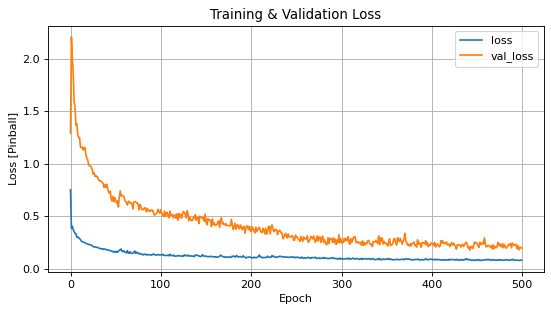

In [36]:
draw_history(histories[0])

In [ ]:
# %tensorboard --logdir logs/fit --host jupyter-server --port=6006

## **Predict**

In [37]:
target_models[0].evaluate(ts_dataset, verbose = 1)

213/213 [==============================] - 0s 830us/step - loss: 0.1871


0.18708056211471558

## **Visualize**

Visualize between label and predictions.

In [40]:
def draw_pred(y_pred, y_true, model_name, save_fig = True):
    plt.figure(figsize = (14, 4), facecolor = "white")
    plt.plot(y_pred, lw = 1.5, label = "Predictions")
    plt.plot(y_true, lw = 1.5, label = "Label")
    
    plt.title(f"Target Model {model_name}", fontsize = "x-large")
    plt.xlabel("Time [day]")
    plt.ylabel("Target [kW]")
    plt.ylim([-2, max(y_true) * 1.1])
    plt.legend()
    
    plt.xticks(np.arange(0, args["WINDOW_INP"] + 1, 24 * 2), [f"D+{i}" for i in np.arange(8)])
    plt.grid(True)
    plt.tight_layout()
    
    if save_fig:
        plt.savefig(f"./pngs/{os.environ['NOTEBOOKNAME']}_target-model-{model_name}.png", dpi = 300)
        
    plt.show()

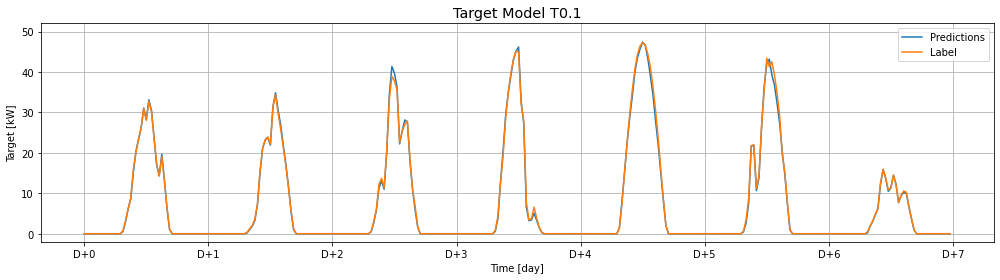

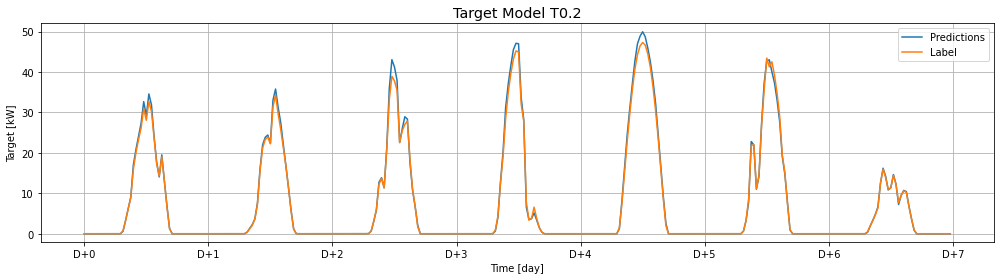

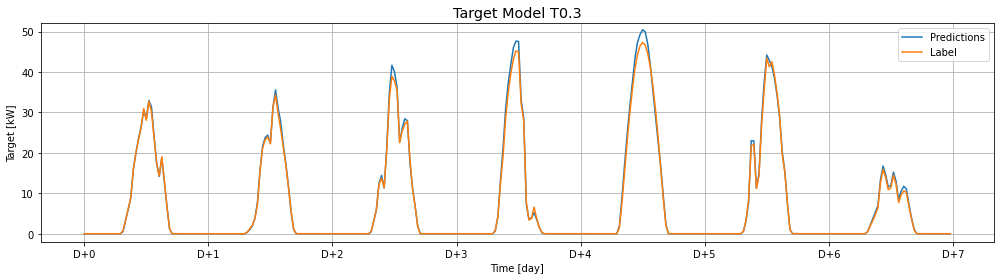

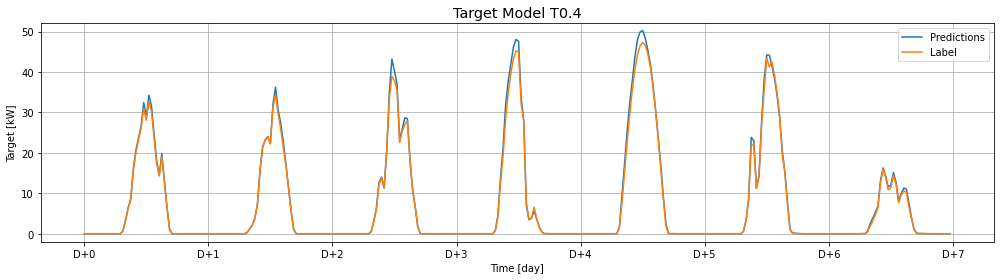

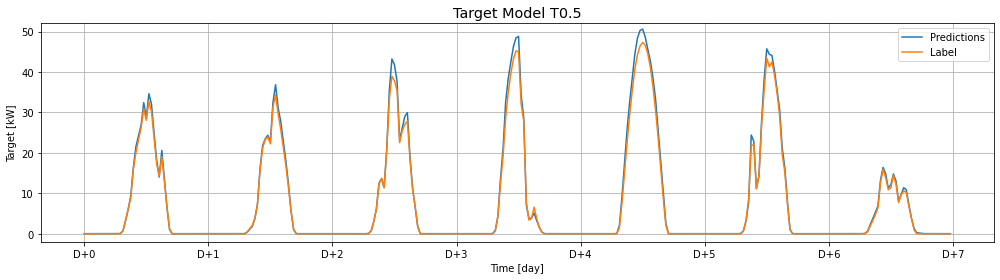

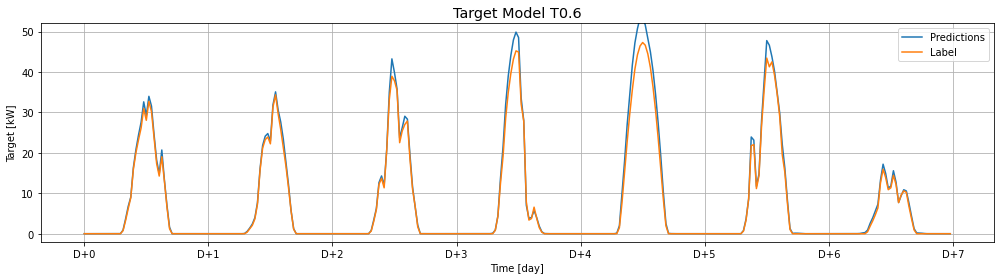

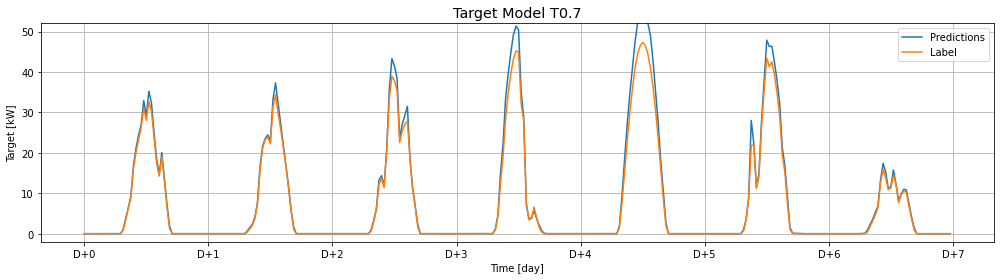

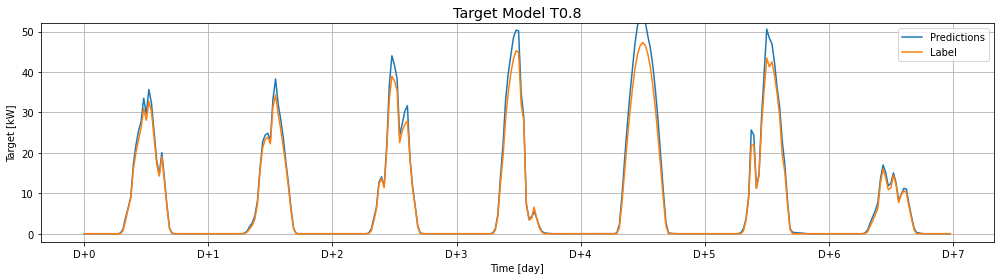

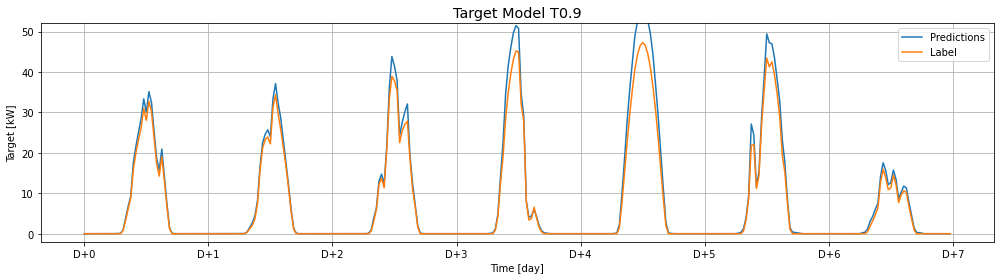

In [41]:
ts_dataset = ts_dataset.unbatch().batch(args["WINDOW_INP"])

for t in ts_dataset.take(1):
    x, y = t # inp, tar
    
    for target_model in target_models:
        draw_pred(y_pred = target_model.predict(x), y_true = y, model_name = target_model.name)

# **Phase \#2: Autoregressive Model**

## **Make Dataset Pipelines**

In [42]:
@tf.function
def _flat_fn_tr(x):
    return x.batch(args["WINDOW_INP"] + args["WINDOW_TAR"])


@tf.function
def _flat_fn_ts(x):
    return x.batch(args["WINDOW_INP"])


@tf.function
def _split_window_tr(features):
    """inp: [batch, 336, 7], tar: [batch, 96, 1]"""
    inp, tar = tf.split(features, [args["WINDOW_INP"], args["WINDOW_TAR"]], axis = 0)
    return inp[..., :-1], tar[..., -1:] 


@tf.function
def _split_window_ts(features):
    """inp: [batch, 336, 7]"""
    return features[..., :-1]

In [43]:
del tr_dataset, vl_dataset, ts_dataset

# tr_tensor = tf.constant(tr_df, dtype = tf.float32)
# vl_tensor = tf.constant(vl_df, dtype = tf.float32)
# ts_tensor = tf.constant(ts_df, dtype = tf.float32)

tr_dataset = tf.data.Dataset.from_tensor_slices(tr_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

vl_dataset = tf.data.Dataset.from_tensor_slices(vl_tensor
                    ).window(args["WINDOW_INP"] + args["WINDOW_TAR"], args["WINDOW_SHIFT"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_tr
                    ).map(_split_window_tr, num_parallel_calls = args["AUTO"]
                    ).batch(args["GLOBAL_BATCH_SIZE"]
                    ).cache(
                    ).prefetch(args["AUTO"])

ts_dataset = tf.data.Dataset.from_tensor_slices(ts_tensor
                    ).window(args["WINDOW_INP"], args["WINDOW_INP"], args["WINDOW_STRIDE"], args["WINDOW_DR"]).flat_map(_flat_fn_ts
                    ).map(_split_window_ts, num_parallel_calls = args["AUTO"]
                    ).batch(args["NUM_TEST_CSV"] # not args["GLOBAL_BATCH_SIZE"]
#                     ).cache(
                    ).prefetch(args["AUTO"])

# Print the shapes
print(f"tr_dataset: {tr_dataset.element_spec}")
print(f"vl_dataset: {vl_dataset.element_spec}")
print(f"ts_dataset: {ts_dataset.element_spec}")

tr_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None))
vl_dataset: (TensorSpec(shape=(None, 336, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name=None))
ts_dataset: TensorSpec(shape=(None, None, 7), dtype=tf.float32, name=None)


### **Take Samples**

In [49]:
for element in tr_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 336, 7) (128, 96, 1)


In [50]:
for element in vl_dataset.take(1):
    foo, bar = element
    print(foo.shape, bar.shape)

(128, 336, 7) (128, 96, 1)


In [51]:
for element in ts_dataset.take(1):
    foo = element
    print(foo.shape)

(81, 336, 7)


## **Create Network**

In [44]:
class AR_LSTM(tf.keras.Model):
    def __init__(self, target_model, units, out_steps, name):
        super(AR_LSTM, self).__init__(name = name)
        self.target_model = target_model # [batch, 7] => [batch, 1]
        self.units = units
        self.out_steps = out_steps
        self.num_features = args["NUM_FEATURES"]
        
        self.lstm_rnn = tf.keras.layers.RNN([
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units),
            tf.keras.layers.LSTMCell(self.units)], return_state = True)
        self.dense = tf.keras.layers.Dense(self.num_features)
        
    
    def warmup(self, inputs):
        # [batch, time, features] => [batch, units]
        x, *state = self.lstm_rnn(inputs)
        # [batch, units] => [batch, num_features]
        prediction = self.dense(x)
        return prediction, state
        
        
    def call(self, inputs, training = None):
        predictions = []
        
        prediction, state = self.warmup(inputs)
        predictions.append(self.target_model(prediction))
        
        for n in range(1, self.out_steps):
            x = tf.expand_dims(prediction, axis = 1)
            # [batch, num_features] => [batch, units]
            x, *state = self.lstm_rnn(x, initial_state = state, training = training)
            # [batch, units] => [batch, num_features]
            prediction = self.dense(x)
            predictions.append(self.target_model(prediction))
            
        predictions = tf.stack(predictions, axis = 1)
        return predictions

## **Compile and Fit**

In [45]:
%%time

target_models.reverse() # to pop
preds = []

for tau in np.arange(0.1, 1, 0.1):
    target_model = target_models.pop()
    target_model.trainable = False # fix the weights
    
    model = AR_LSTM(
        target_model = target_model,
        units = args["NUM_UNITS"],
        out_steps = args["WINDOW_TAR"],
        name = f"P{tau:.1f}")

    model.compile(
        loss = tfa.losses.PinballLoss(tau = tau),
        optimizer = tf.keras.optimizers.Adam(args["INIT_LR"]))
    
    # Early stopping callback to restore best weights.
    es_callback = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
    
    # TensorBoard callback to visualize loss & val_loss.
    log_dir = os.path.join(
        "logs", "fit", os.environ["NOTEBOOKNAME"], 
        datetime.datetime.now().strftime(f"{model.name}-%Y%m%d-%H%M%S"))
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    print(f"\nModel {model.name}...\n")
    
    _ = model.fit(
        tr_dataset,
        validation_data = vl_dataset,
        epochs = args["EPOCH"],
        verbose = 2,
        callbacks = [es_callback, tb_callback])
    
    preds.append(np.array(model.predict(ts_dataset))[..., 0])
    
    del target_model, model # to save memories    
    gc.collect()


Model P0.1...

Epoch 1/10
7/7 - 163s - loss: 2.3582 - val_loss: 1.8457
Epoch 2/10
7/7 - 6s - loss: 1.8661 - val_loss: 1.8350
Epoch 3/10
7/7 - 6s - loss: 1.8395 - val_loss: 1.7954
Epoch 4/10
7/7 - 6s - loss: 1.8093 - val_loss: 1.7820
Epoch 5/10
7/7 - 6s - loss: 1.8067 - val_loss: 1.7882
Epoch 6/10
7/7 - 6s - loss: 1.8074 - val_loss: 1.7829
Epoch 7/10
7/7 - 6s - loss: 1.7997 - val_loss: 1.7728
Epoch 8/10
7/7 - 5s - loss: 1.7894 - val_loss: 1.7688
Epoch 9/10
7/7 - 6s - loss: 1.7877 - val_loss: 1.7681
Epoch 10/10
7/7 - 5s - loss: 1.7881 - val_loss: 1.7648

Model P0.2...

Epoch 1/10
7/7 - 164s - loss: 4.8813 - val_loss: 3.6827
Epoch 2/10
7/7 - 6s - loss: 3.7179 - val_loss: 3.6971
Epoch 3/10
7/7 - 6s - loss: 3.6979 - val_loss: 3.5972
Epoch 4/10
7/7 - 5s - loss: 3.6067 - val_loss: 3.5654
Epoch 5/10
7/7 - 6s - loss: 3.5901 - val_loss: 3.5431
Epoch 6/10
7/7 - 6s - loss: 3.5808 - val_loss: 3.5393
Epoch 7/10
7/7 - 5s - loss: 3.5782 - val_loss: 3.5350
Epoch 8/10
7/7 - 6s - loss: 3.5741 - val_loss

In [ ]:
# models[0].summary()

In [ ]:
# %tensorboard --logdir logs/fit --host jupyter-server --port=6006

## **Predict**

In [49]:
submission = pd.read_csv(os.path.join(os.environ["LOCAL_DATA_PATH"], "sample_submission.csv"), index_col = "id")
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
for column, pred in zip(submission.columns, preds):
    foo = np.reshape(pred, (-1,))
#     foo = (foo * args["TARGET_STD"]) + args["TARGET_STD"]
#     foo = np.where(foo < 0, 0, foo) # clip by value
    
    submission[column] = foo

In [51]:
submission.head()

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,-0.060845,-0.056208,-0.056574,-0.301719,-0.345327,0.136822,-0.439915,-0.012363,-0.206137
0.csv_Day7_0h30m,-0.054991,-0.062896,-0.075801,-0.311273,-0.417758,0.128121,-0.365220,0.017163,-0.269114
0.csv_Day7_1h00m,-0.048719,-0.064844,-0.087164,-0.310487,-0.478396,0.121860,-0.266355,0.104860,-0.305148
0.csv_Day7_1h30m,-0.042895,-0.062891,-0.089894,-0.299977,-0.528175,0.119477,-0.145487,0.336239,-0.316208
0.csv_Day7_2h00m,-0.036997,-0.058795,-0.086052,-0.279633,-0.561041,0.121054,-0.048785,1.743204,-0.301814


In [52]:
submission.to_csv(
    os.path.join(os.environ["SUBMISSION_PATH"], f"{os.environ['NOTEBOOKNAME']}_submission.csv"))